`````{note}
This lecture is going to:
* introduce the concepts of active learning or design of experiments
* discuss the tradeoffs between exploration and exploitation
* show several baseline exploration strategies
    * random sampling
    * latin hypercube sampling
    * sobol sampling
* show how one open source package (scikit-optimize) uses sklearn GP regressors to implement this
* demonstrate this for a physical experiment by optimizing paper helicopters using sigopt!
`````

# Design of Experiments (Active Learning) with Bayesian Optimization


Design of Experiments (DoE), or active learning, is the research area of choosing which parameters to sample to learn about or optimize some system (usually an experiment or expensive simulation).

A few common use cases:
* We want to maximize/minimize some metric
    * Tune elemental composition to optimize some property
    * Fine the best temperature to operate some process
* Build a surrogate (fast) model for some experimental process
    * Develop a ML model that can reproduce the output of a large chemical plant
    
We will repeatedly sample a process and use that information to select new points to sample. We will try to accomplish some goal with the minimum number of evaluations. There are many strategies that we can use.



## Trial Function

As a trial function, let's try to find the highest value of the function 
\begin{align*}
y=x^2\sin(5\pi x)^6 + \epsilon
\end{align*}
where $\epsilon$ is random noise with a scale of 0.1. We'll limit ourselves to the region $x\in[0,1]$.

Let's define and plot the objective function first!

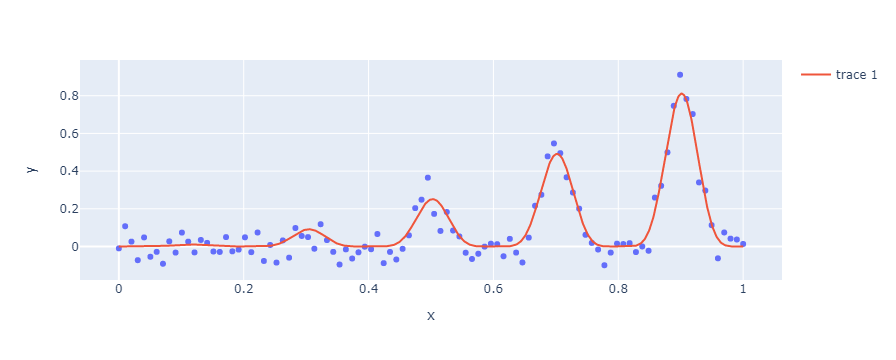

In [1]:
import numpy as np
import plotly.express as px


def objective(x, noise=0.05):
    noise = np.random.normal(loc=0, scale=noise, size=x.shape)
    return (x**2 * np.sin(5 * np.pi * x) ** 6.0) + noise


# Plot the objective function evaluated at 100 evenly spaced points
x_eval = np.linspace(0, 1, 100)
fig = px.scatter(x=x_eval, y=objective(x_eval))

# Add a line for the actual function evaluation!
x_eval = np.linspace(0, 1, 1000)
fig.add_scatter(x=x_eval, y=objective(x_eval, noise=0))

There are five local maxima in this range. The noise is significant here. The best maxima is the one to the right. We got this by doing 100 function evaluations. 

## Uniform or random sampling strategies

If we don't want to build a model or do local optimizations, we can try to optimize a function $f(x,y)$ by randomly sampling with various parameters. Three of the most common strategies are:
* **random sampling:** Just pick random parameters and try them
* **latin hypercube sampling:** try to pick points to improve the variability of the outputs
* **Sobol sampling:** try to pick random points with the goal of equally covering the entire space and then going back and filling in the space

These are pretty simple, but usually helpful for selecting the first points to try. A rough rule of thumb is to sample ~5-10 or ~2D (where D is the number of dimensions) points before trying to use a fancy ML based method if you don't know anything about the system. Let's visualize the strategies in two dimensions!

In [2]:
import numpy as np
from scipy.stats import qmc

N = 50

# Generate N random samples in two dimensions
random_samples = np.random.uniform(0, 1, size=(N, 2))

# Generate N latin hypercube samples
latin_hypercube_samples = qmc.LatinHypercube(2).random(N)

# Generate N sobol samples in two dimensions
sobol_samples = qmc.Sobol(d=2, scramble=True).random(N)

/tmp/ipykernel_167/2070957824.py:13: UserWarning:

The balance properties of Sobol' points require n to be a power of 2.



Now let's make a little animation to see how the differenget 

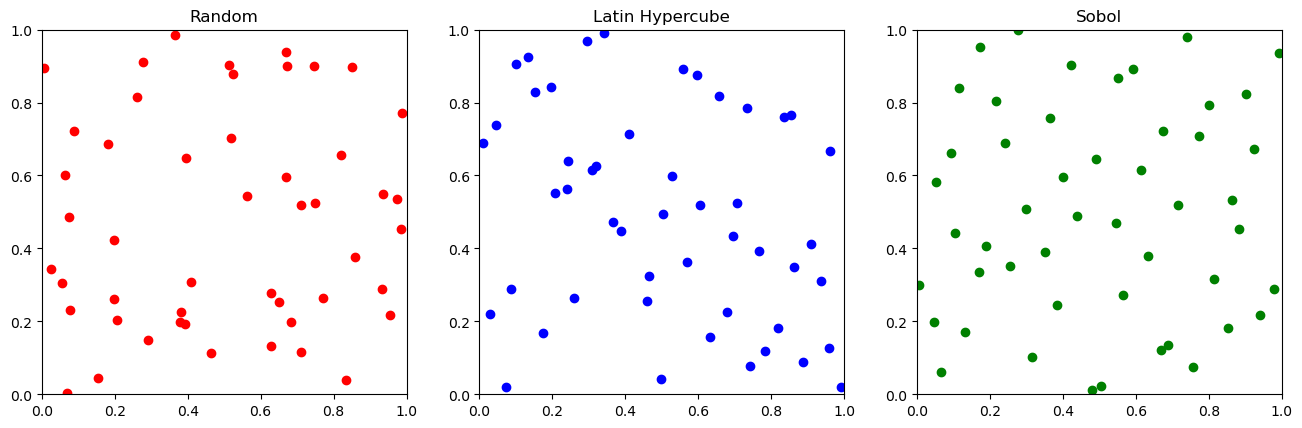

In [3]:
# Make a matplotlib animation!

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation, rc

# Make the plots
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(16, 9))
(pt_random,) = ax[0].plot([], [], "ro")
(pt_latin_hypercube,) = ax[1].plot([], [], "bo")
(pt_sobol,) = ax[2].plot([], [], "go")
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0, 1)
ax[0].set_adjustable("box")
ax[0].set_aspect("equal")
ax[0].set_title("Random")
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 1)
ax[1].set_aspect("equal")
ax[1].set_adjustable("box")
ax[1].set_title("Latin Hypercube")
ax[2].set_xlim(0, 1)
ax[2].set_ylim(0, 1)
ax[2].set_aspect("equal")
ax[2].set_adjustable("box")
ax[2].set_title("Sobol")

# Initialize and clear the data!
def init():
    pt_random.set_data([], [])
    pt_latin_hypercube.set_data([], [])
    pt_sobol.set_data([], [])

    return (pt_random, pt_latin_hypercube, pt_sobol)


def animate(i):
    # Set the data for a given frame
    pt_random.set_data(random_samples[:i, 0], random_samples[:i, 1])
    pt_latin_hypercube.set_data(
        latin_hypercube_samples[:i, 0], latin_hypercube_samples[:i, 1]
    )
    pt_sobol.set_data(sobol_samples[:i, 0], sobol_samples[:i, 1])

    return (pt_random, pt_latin_hypercube, pt_sobol)


# Make the animation!
anim = animation.FuncAnimation(
    fig,
    animate,
    init_func=init,
    frames=N,
    interval=1000,
    repeat_delay=5000,
    blit=True,
)

rc("animation", html="jshtml")
anim

## Evaluation of simple sampling strategies on optimizing the test function

Let's see how these three strategies work for sampling the test function above. 

### Base case: random sampling

The easiest thing we can do is randomly pick points in the range. For a given number of random samples, we can evaluate all of them and see what the best is!

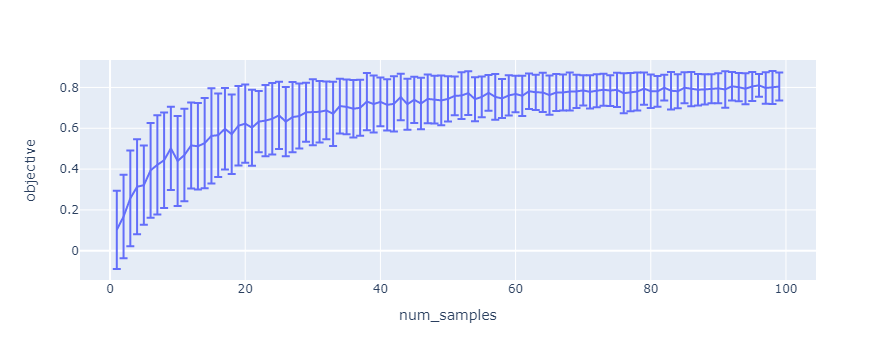

In [4]:
import pandas as pd

# Make an empty dataframe!
df_random = pd.DataFrame()

num_samples = list(range(1, 100))

for n in num_samples:

    # Run 10 trials with n samples!
    y = [np.max(objective(np.random.uniform(0, 1, size=(n,)))) for i in range(100)]

    # Add the results to the dataframe
    df_random = pd.concat(
        (
            df_random,
            pd.DataFrame(
                {"num_samples": [n], "objective": [np.mean(y)], "stdev": [np.std(y)]}
            ),
        ),
        ignore_index=True,
    )

# Plot with error bars!
px.line(df_random, x="num_samples", y="objective", error_y="stdev")

Note that our process - pick the best value of the random points is actually not giving us quite the right answer when we evaluate many times, since we also have a bit of noise in the measurements!

We can see that to get close to the real value of ~0.80 we need ~80 function evaluations. At 20 evaluations our best value is ~0.65. 

### Latin hypercube sampling

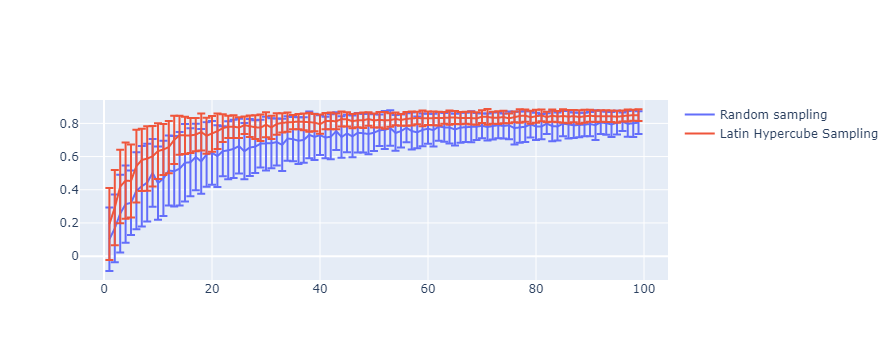

In [5]:
import pandas as pd
import plotly.graph_objects as go
from scipy.stats import qmc

# Make an empty dataframe!
df_latinhypercube = pd.DataFrame()

num_samples = list(range(1, 100))

for n in num_samples:

    # Run 10 trials with n samples!
    y = [np.max(objective(qmc.LatinHypercube(2).random(n))) for i in range(100)]

    # Add the results to the dataframe
    df_latinhypercube = pd.concat(
        (
            df_latinhypercube,
            pd.DataFrame(
                {"num_samples": [n], "objective": [np.mean(y)], "stdev": [np.std(y)]}
            ),
        ),
        ignore_index=True,
    )

fig = go.Figure()
fig.add_scatter(
    x=df_random["num_samples"],
    y=df_random["objective"],
    error_y={"array": df_random["stdev"]},
    name="Random sampling",
)
fig.add_scatter(
    x=df_latinhypercube["num_samples"],
    y=df_latinhypercube["objective"],
    error_y={"array": df_latinhypercube["stdev"]},
    name="Latin Hypercube Sampling",
)

Notice how much better latin hypercube sampling works for this process! At 20 evaluations our best value is ~0.73. The gap is pretty consistent at all sample sizes. 

### Sobol Sampling

/tmp/ipykernel_167/1287512983.py:13: UserWarning:

The balance properties of Sobol' points require n to be a power of 2.



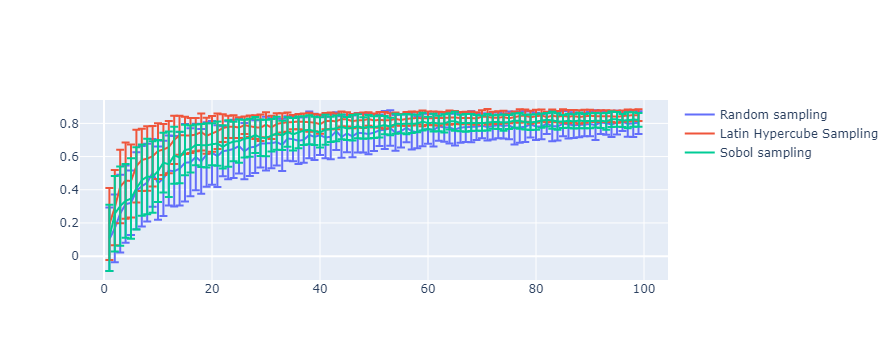

In [6]:
import pandas as pd
import plotly.graph_objects as go
from scipy.stats import qmc

# Make an empty dataframe!
df_sobol = pd.DataFrame()

num_samples = list(range(1, 100))

for n in num_samples:

    # Run 10 trials with n samples!
    y = [np.max(objective(qmc.Sobol(d=1, scramble=True).random(n))) for i in range(100)]

    # Add the results to the dataframe
    df_sobol = pd.concat(
        (
            df_sobol,
            pd.DataFrame(
                {"num_samples": [n], "objective": [np.mean(y)], "stdev": [np.std(y)]}
            ),
        ),
        ignore_index=True,
    )

fig = go.Figure()
fig.add_scatter(
    x=df_random["num_samples"],
    y=df_random["objective"],
    error_y={"array": df_random["stdev"]},
    name="Random sampling",
)
fig.add_scatter(
    x=df_latinhypercube["num_samples"],
    y=df_latinhypercube["objective"],
    error_y={"array": df_latinhypercube["stdev"]},
    name="Latin Hypercube Sampling",
)
fig.add_scatter(
    x=df_sobol["num_samples"],
    y=df_sobol["objective"],
    error_y={"array": df_sobol["stdev"]},
    name="Sobol sampling",
)

## Bayesian Optimization with `scikit-optimize`

Bayesian optimization is one approach in a field of methods called "sequential model based optimization". The general idea is
1. Generate a few (~2-3 times the number of variables?) random configurations in your range of interest and evaluate them
2. Fit the best Gaussian Process you can to your data
3. Ask the GP which new value is most likely to improve on the current best known point (**expected improvement**)
4. Sample that point and add it to the dataset
5. Go back to 2.

This is one of many, many, many possible strategies you can use! The key is to trade-off exploration vs exploitation
* **exploration:** try something new you know little about and hope it is significantly better than your current best
* **exploitation:** try to incrementally improve your current best solution

`scikit-optimize` is one framework among many for handling this loop using various types of Gaussian Process models.

`````{seealso}
https://scikit-optimize.github.io/stable/index.html
`````

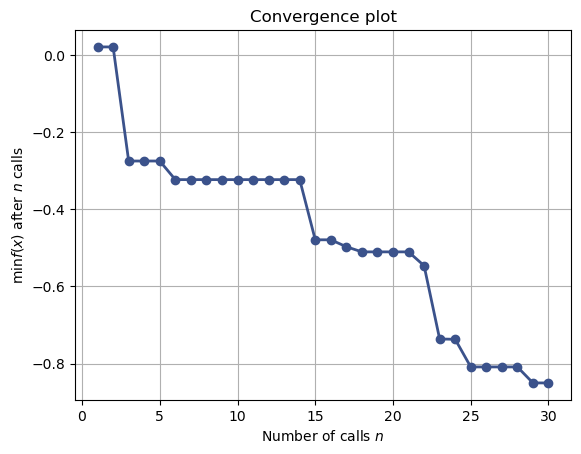

In [107]:
from skopt import gp_minimize


def objective(x, noise=0.05):
    (x,) = x
    noise = np.random.normal(loc=0, scale=noise)
    
    # Notice the - sign! we want to maximize this
    return -(x**2 * np.sin(5 * np.pi * x) ** 6.0) + noise


res = gp_minimize(
    objective,  # the function to minimize
    [(0.0, 1.0)],  # the bounds on each dimension of x
    acq_func="EI",  # the acquisition function
    n_calls=30,  # the number of evaluations of f
    n_random_starts=5,  # the number of random initialization points
    noise=0.1**2,  # the noise level (optional)
    initial_point_generator="lhs"
)  # the random seed

from skopt.plots import plot_convergence

plot_convergence(res);

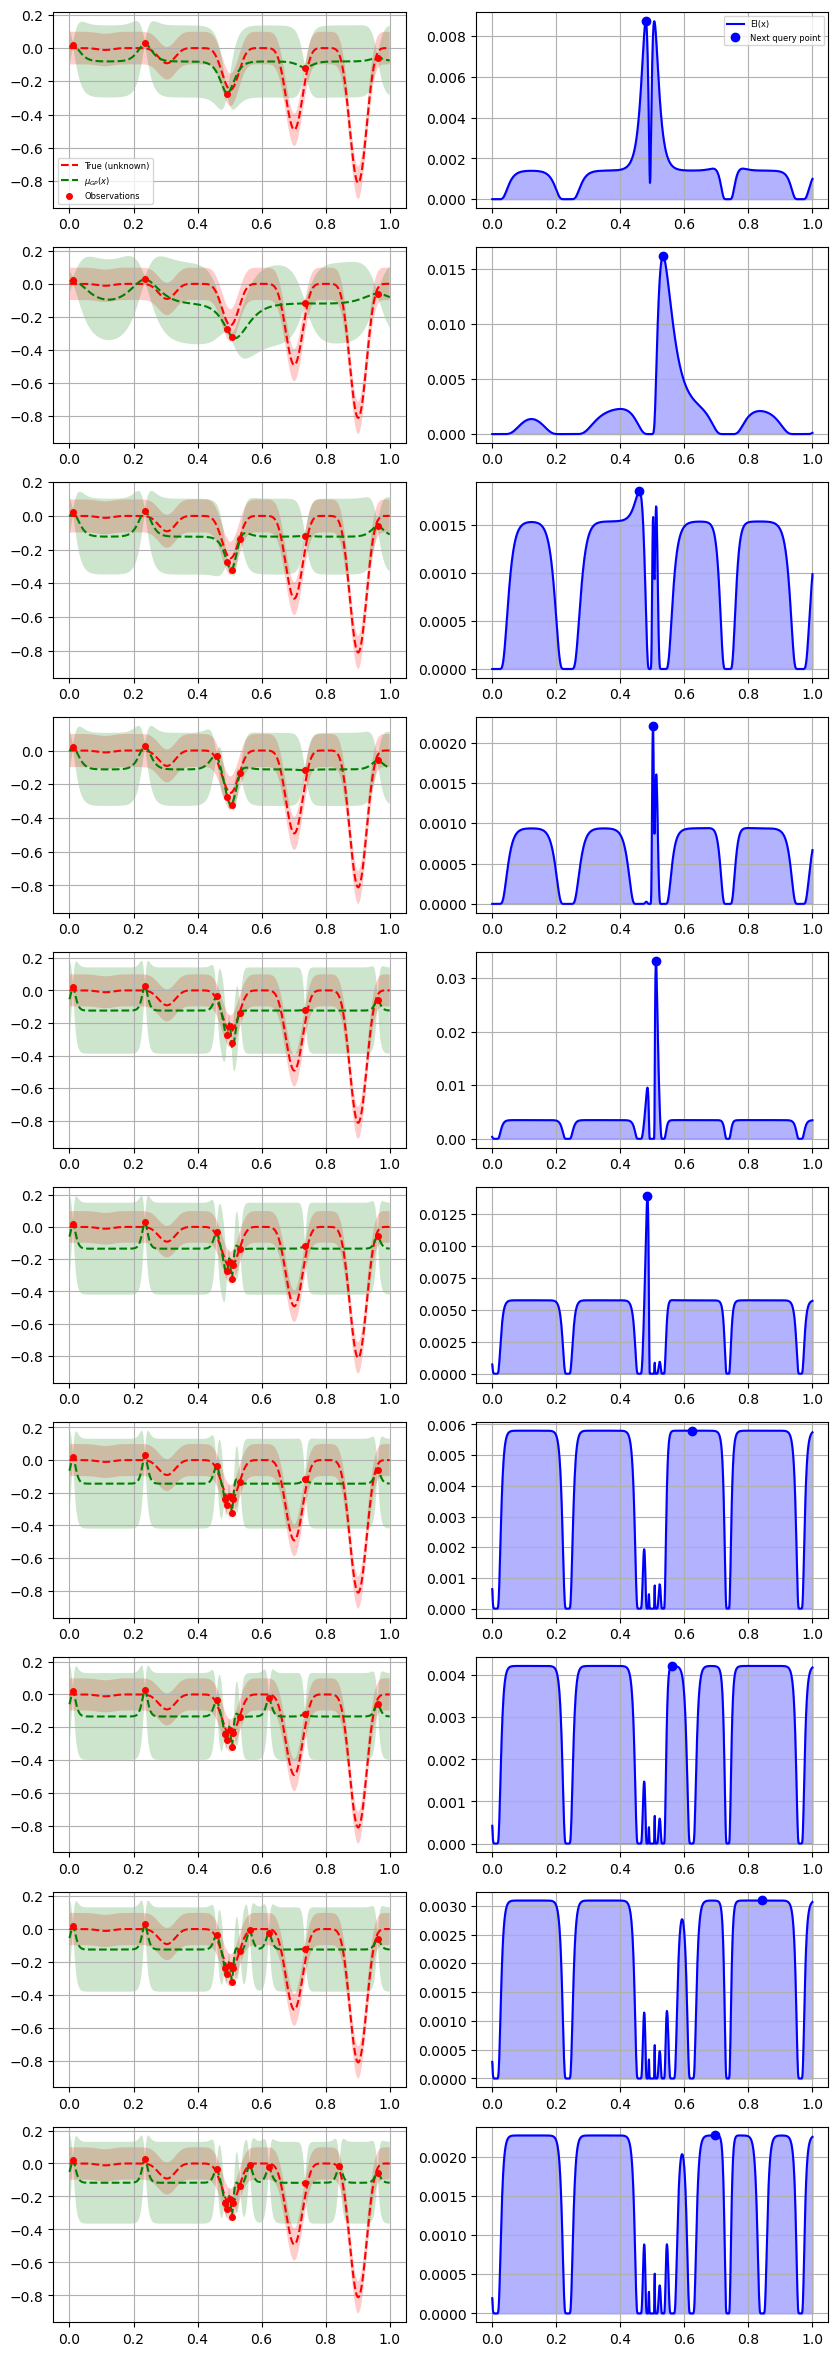

In [108]:
from skopt.plots import plot_gaussian_process

for n_iter in range(10):
    # Plot true function.

    plt.subplot(10, 2, 2 * n_iter + 1)

    if n_iter == 0:
        show_legend = True
    else:
        show_legend = False

    ax = plot_gaussian_process(
        res,
        n_calls=n_iter,
        objective=lambda x: objective(x, 0),
        noise_level=0.05,
        show_legend=show_legend,
        show_title=False,
        show_next_point=False,
        show_acq_func=False,
    )
    ax.set_ylabel("")
    ax.set_xlabel("")

    # Plot EI(x)
    plt.subplot(10, 2, 2 * n_iter + 2)
    ax = plot_gaussian_process(
        res,
        n_calls=n_iter,
        show_legend=show_legend,
        show_title=False,
        show_mu=False,
        show_acq_func=True,
        show_observations=False,
        show_next_point=True,
    )
    ax.set_ylabel("")
    ax.set_xlabel("")

fig = plt.gcf()
fig.set_figheight(30)
fig.set_figwidth(10)
plt.show()

Let's compare this to our much simpler sampling strategies!

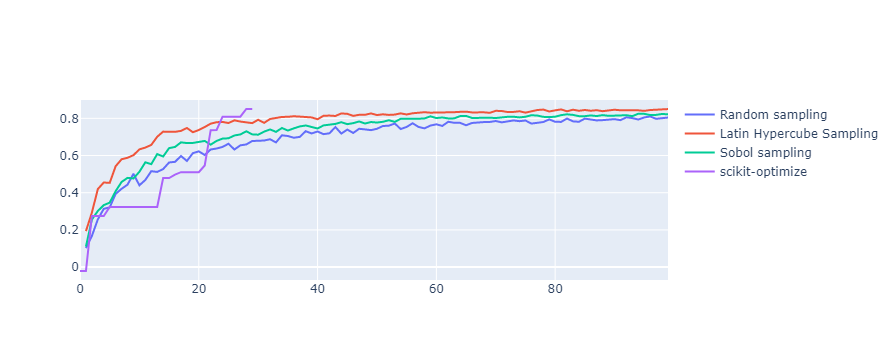

In [109]:
fig = go.Figure()
fig.add_scatter(
    x=df_random["num_samples"],
    y=df_random["objective"],
    # error_y={"array": df_random["stdev"]},
    name="Random sampling",
)
fig.add_scatter(
    x=df_latinhypercube["num_samples"],
    y=df_latinhypercube["objective"],
    # error_y={"array": df_latinhypercube["stdev"]},
    name="Latin Hypercube Sampling",
)
fig.add_scatter(
    x=df_sobol["num_samples"],
    y=df_sobol["objective"],
    # error_y={"array": df_sobol["stdev"]},
    name="Sobol sampling",
)

fig.add_scatter(
    x=list(range(len(res.func_vals))),
    y=np.maximum.accumulate(-res.func_vals),
    name="scikit-optimize",
)

## In-class experiment: paper helicopters!

We will demonstrate DoE starting from scratch for a physical system using an online service (SigOpt, now a subsidiary of Intel) to optimize a number of parameters for paper helicopter flight time! This demonstration will show:
* how DoE can be used in real life
* parameter constraints
* uncertainty in experimental data
* analysis and visualization of high dimension experiments

SigOpt takes care of many of the details of actually building a predictive model for your data. They make this process very straightforward. There are many open source alternatives that could also be used, but they take a bit more time to learn/use:
* hyperopt
* scikit-optimize
* ax
* gpyopt
* wandb
* ...

Spreadsheet for the experiments for this class! (CMU access only, so use your CMU google account)
https://docs.google.com/spreadsheets/d/1Is9t9-sknFipdiN5MvuOyMCScjjv2JXGu0Ou4Gzlh_g/edit#gid=0